Analyzing data from: data/raw/nba_games_raw_20250317_151003.csv
Loaded 18904 total records

1. RECORDS PER SEASON:
SEASON
2017-18    2785
2018-19    2788
2019-20    2516
2020-21    2442
2021-22    2788
2022-23    2790
2023-24    2795
Name: count, dtype: int64

2. UNIQUE GAMES PER SEASON:
SEASON
2017-18    1392
2018-19    1394
2019-20    1258
2020-21    1221
2021-22    1394
2022-23    1395
2023-24    1397
Name: GAME_ID, dtype: int64

3. RECORDS PER UNIQUE GAME (should be close to 2.0):
SEASON
2017-18    2.000718
2018-19    2.000000
2019-20    2.000000
2020-21    2.000000
2021-22    2.000000
2022-23    2.000000
2023-24    2.000716
dtype: float64

4. HOME VS AWAY BALANCE:
Overall Home/Away distribution:
LOCATION
Home    9452
Away    9452
Name: count, dtype: int64

Home/Away distribution by season:
LOCATION  Away  Home
SEASON              
2017-18   1393  1392
2018-19   1394  1394
2019-20   1258  1258
2020-21   1221  1221
2021-22   1394  1394
2022-23   1395  1395
2023-24   1397  1398

Home

/var/folders/4p/k3p3mnfx6zx1711_f5mhdlcr0000gn/T/ipykernel_39715/4150404248.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Season', y='Completeness %', data=completeness_df, palette='viridis')


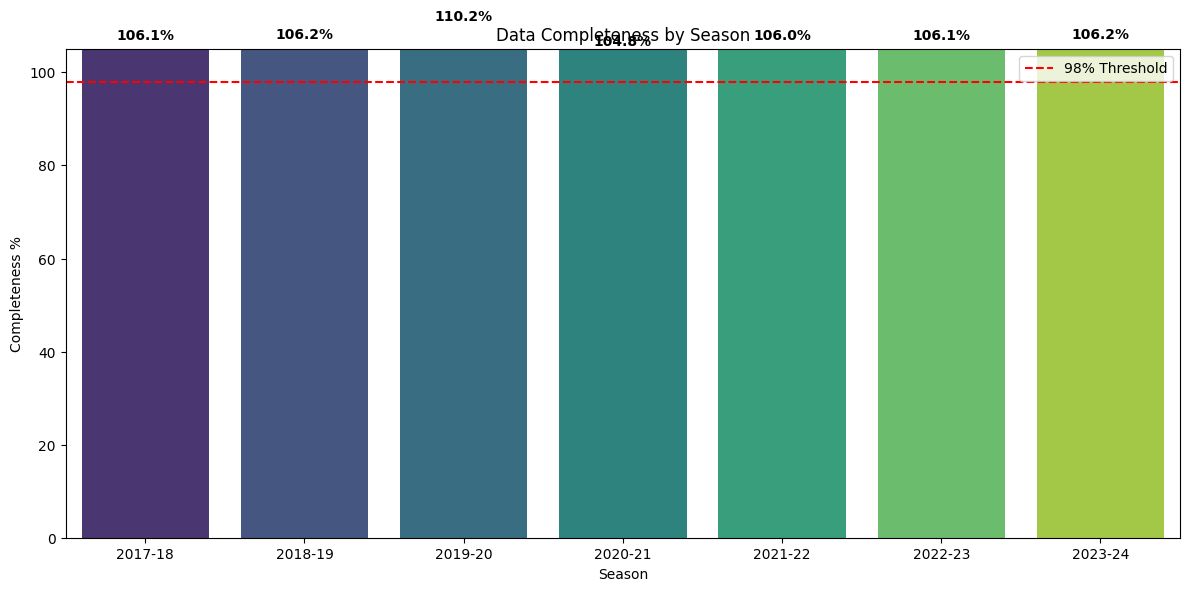


7. OVERALL ASSESSMENT:
✅ SUCCESS: All seasons appear to have complete data (98%+ of expected games)


In [3]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

def verify_nba_data_completeness():
    """
    Comprehensive verification of NBA game data completeness.
    This function checks if our collected data contains the expected
    number of games for each season with proper team representation.
    """
    # Find the most recent complete game data file
    game_files = glob.glob('data/raw/nba_games_raw_*.csv')
    if not game_files:
        print("No game data files found!")
        return
        
    latest_file = max(game_files, key=os.path.getctime)
    print(f"Analyzing data from: {latest_file}")
    
    # Load the data
    games_df = pd.read_csv(latest_file)
    print(f"Loaded {len(games_df)} total records")
    
    # 1. Basic season record counts
    season_counts = games_df['SEASON'].value_counts().sort_index()
    print("\n1. RECORDS PER SEASON:")
    print(season_counts)
    
    # 2. Unique games per season
    unique_games = games_df.groupby('SEASON')['GAME_ID'].nunique()
    print("\n2. UNIQUE GAMES PER SEASON:")
    print(unique_games)
    
    # 3. Calculate records-per-game ratio (should be close to 2.0)
    ratio = season_counts / unique_games
    print("\n3. RECORDS PER UNIQUE GAME (should be close to 2.0):")
    print(ratio)
    
    # 4. Check home vs away balance
    if 'MATCHUP' in games_df.columns:
        print("\n4. HOME VS AWAY BALANCE:")
        
        # Define a function to identify home/away status
        def get_location(matchup):
            if 'vs.' in matchup or 'vs ' in matchup:
                return 'Home'
            elif '@' in matchup:
                return 'Away'
            else:
                return 'Unknown'
        
        # Add location column
        games_df['LOCATION'] = games_df['MATCHUP'].apply(get_location)
        
        # Check overall balance
        location_counts = games_df['LOCATION'].value_counts()
        print("Overall Home/Away distribution:")
        print(location_counts)
        
        # Check balance by season
        season_location = pd.crosstab(games_df['SEASON'], games_df['LOCATION'])
        print("\nHome/Away distribution by season:")
        print(season_location)
        
        # Calculate home/away ratio by season (should be close to 1.0)
        if 'Home' in season_location.columns and 'Away' in season_location.columns:
            ha_ratio = season_location['Home'] / season_location['Away']
            print("\nHome/Away ratio by season (should be close to 1.0):")
            print(ha_ratio)
    
    # 5. Check expected game counts against known NBA season lengths
    print("\n5. COMPLETENESS CHECK AGAINST EXPECTED VALUES:")
    
    # Define expected games for regular seasons
    # Note: 2019-20 and 2020-21 had fewer games due to COVID-19
    expected_regular_season = {
        '2017-18': 1230,  # 30 teams * 82 games / 2
        '2018-19': 1230,
        '2019-20': 1059,  # COVID-shortened season
        '2020-21': 1080,  # Reduced 72-game season
        '2021-22': 1230,
        '2022-23': 1230,
        '2023-24': 1230
    }
    
    # Add approximate playoff games (varies by season)
    playoff_games = {
        '2017-18': 82,
        '2018-19': 82,
        '2019-20': 83,  # Bubble playoffs
        '2020-21': 85,
        '2021-22': 85,
        '2022-23': 85,
        '2023-24': 85  # Estimate
    }
    
    # Calculate total expected games and compare to actual
    completeness_results = []
    for season in unique_games.index:
        if season in expected_regular_season:
            expected = expected_regular_season[season] + playoff_games.get(season, 85)
            actual = unique_games[season]
            percent = (actual / expected) * 100
            completeness_results.append({
                'Season': season,
                'Expected Games': expected,
                'Actual Games': actual,
                'Completeness %': percent,
                'Status': 'Complete' if percent >= 98 else 'Incomplete'
            })
    
    completeness_df = pd.DataFrame(completeness_results)
    print(completeness_df)
    
    # 6. Visualize completeness
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Season', y='Completeness %', data=completeness_df, palette='viridis')
    plt.title('Data Completeness by Season')
    plt.axhline(y=98, color='red', linestyle='--', label='98% Threshold')
    plt.xlabel('Season')
    plt.ylabel('Completeness %')
    plt.ylim(0, 105)
    
    # Add value labels on bars
    for i, row in enumerate(completeness_results):
        plt.text(i, row['Completeness %'] + 1, f"{row['Completeness %']:.1f}%", 
                 ha='center', fontweight='bold')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 7. Summary assessment
    print("\n7. OVERALL ASSESSMENT:")
    all_complete = all(row['Completeness %'] >= 98 for row in completeness_results)
    if all_complete:
        print("✅ SUCCESS: All seasons appear to have complete data (98%+ of expected games)")
    else:
        incomplete = [row['Season'] for row in completeness_results if row['Completeness %'] < 98]
        print(f"⚠️ WARNING: The following seasons may have incomplete data: {', '.join(incomplete)}")
        print("   Consider re-running the data collection for these seasons.")

# Run the verification
verify_nba_data_completeness()